In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [26]:
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter

height, width = 224, 224
batch_size=64


def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

TRAINING_DIR = '/content/drive/MyDrive/COVID19-DATASET/Covid19-dataset/train'
TESTING_DIR = '/content/drive/MyDrive/COVID19-DATASET/Covid19-dataset/test'

train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
             'Covid_cases':len(np.where(total_image==2)[0])})

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


 {'Normal_cases': 90, 'Viral_Pneumonia_cases': 90, 'Covid_cases': 137}


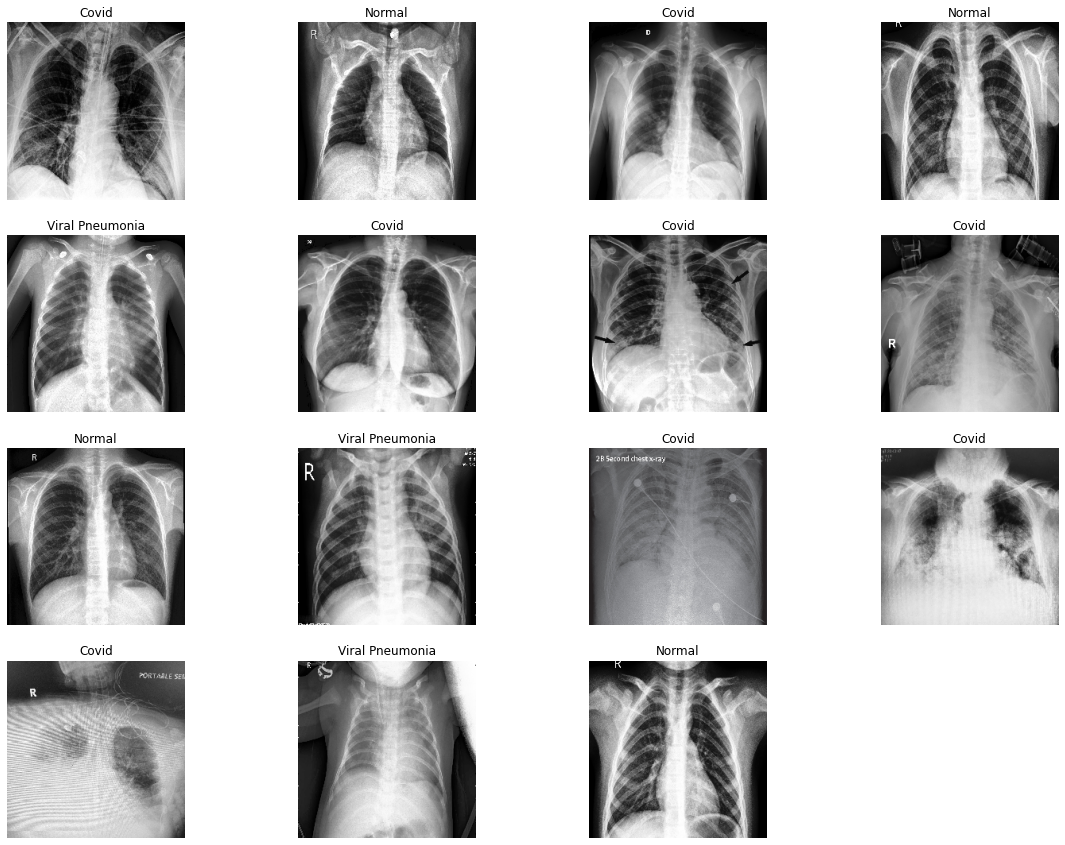

In [28]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Normal" if img_label[i] == 0 else "Viral Pneumonia" if img_label[i] == 1 else "Covid")
        plt.axis("off")

image_plot(train_generator,15)

In [29]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.GlobalAveragePooling2D())

model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))

model_vgg16.add(tf.keras.layers.Dense(3, activation='softmax'))

model_vgg16.compile(loss='SparseCategoricalCrossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                        

In [30]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        train_generator,
        validation_data = test_generator,
        #steps_per_epoch=10,
        epochs=10, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/10
4/4 [==============================] - ETA: 0s - loss: 1.2078 - acc: 0.3865 
Epoch 1: acc improved from -inf to 0.38645, saving model to model/vgg16_best.h5
4/4 [==============================] - 163s 41s/step - loss: 1.2078 - acc: 0.3865 - val_loss: 1.0450 - val_acc: 0.3939
Epoch 2/10
4/4 [==============================] - ETA: 0s - loss: 1.1162 - acc: 0.4343 
Epoch 2: acc improved from 0.38645 to 0.43426, saving model to model/vgg16_best.h5
4/4 [==============================] - 155s 40s/step - loss: 1.1162 - acc: 0.4343 - val_loss: 0.9682 - val_acc: 0.3939
Epoch 3/10
4/4 [==============================] - ETA: 0s - loss: 0.9845 - acc: 0.5219 
Epoch 3: acc improved from 0.43426 to 0.52191, saving model to model/vgg16_best.h5
4/4 [==============================] - 155s 41s/step - loss: 0.9845 - acc: 0.5219 - val_loss: 0.8984 - val_acc: 0.6515
Epoch 4/10
4/4 [==============================] - ETA: 0s - loss: 0.9071 - acc: 0.5339 
Epoch 4: acc improved from 0.52191 to 0.53386

##**PLOTS FOR TRAINING VS VALIDATION ACCURACY AND TRAINING VS VALIDATION LOSS**

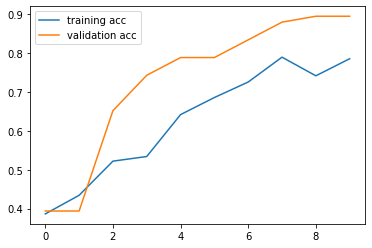

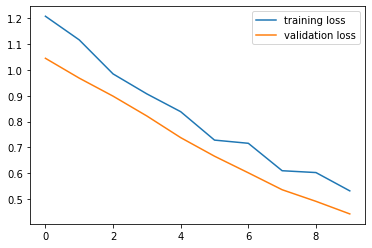

In [31]:
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history)

###INFERENCE 1: **FOR TRAINING, VALIDATION AND TRAINING ACCURACIES INTERSECT AT 0.44 BEYOND WHICH VALIDATION ACCURACY IS GREATER THAN TRAINING ACCURACY**

###INFERENCE 2: **FOR TESTING, VALIDATION LOSS IS ALWAYS LESSER THAN TRAINING LOSS WHILE TRAINING LOSS INCREASES AND DECREASES AS EPOCHS INCREASES.**

##**VALUES FOR ABOVE PLOTS**

In [32]:
train_result = model_vgg16.evaluate(train_generator)
test_result = model_vgg16.evaluate(test_generator)

no_augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

2/2 [==============================] - 32s 916ms/step - loss: 0.4424 - acc: 0.8939


,Train,Val
Loss,0.440001,0.442422
Acc,0.876494,0.893939


##CLASSIFICATION REPORT AND CONFUSION MATRIX

3/3 [==============================] - 30s 8s/step
              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86        20
         1.0       0.88      0.75      0.81        20
         2.0       0.96      1.00      0.98        26

    accuracy                           0.89        66
   macro avg       0.89      0.88      0.88        66
weighted avg       0.89      0.89      0.89        66



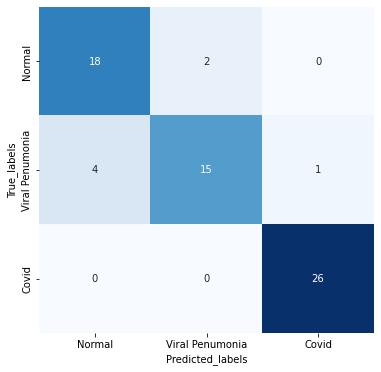

In [33]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest= np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_vgg16.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))

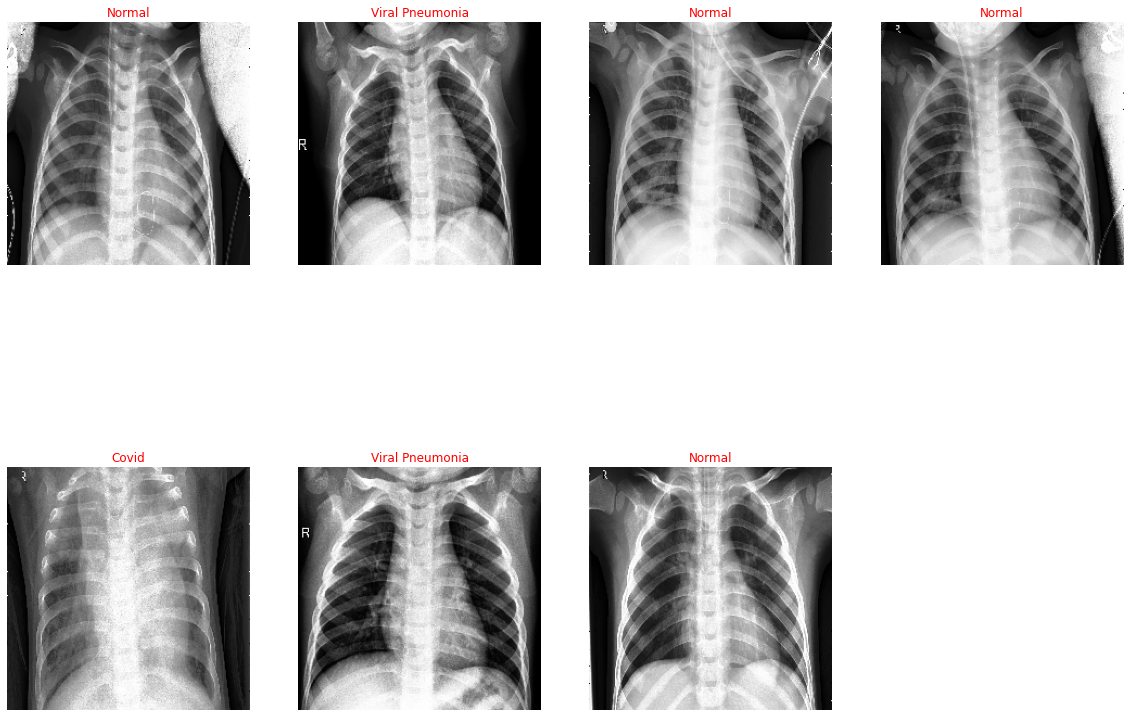

In [35]:
wrong_pred = np.where(ypred!=ytest)[0]

plt.figure(figsize=(20, 15))
for i,n in enumerate(wrong_pred):
    ax = plt.subplot(math.ceil(len(wrong_pred)/4),4, i + 1)
    plt.imshow(xtest[n])
    plt.title("Normal" if ypred[n] == 0 else "Viral Pneumonia" if ypred[n] == 1 else "Covid",color='r')
    plt.axis("off")